# Import variables

参考

https://disassemble-channel.com/lstm-multivariate-time-series/

In [3]:
template1=(8, 5) # figサイズのテンプレート

# exDataIsAll=True  
exDataIsAll=False

num_of_lstm_layer = 1

epochs=30
window_size=24

In [251]:
import datetime
import os
# 実行ごとにディレクトリを作成
start_time = datetime.datetime.now()
dir_str = start_time.strftime('%Y%m%d-%H%M-%S')   #20240914-1930-00
directory = f'./pickles/{dir_str}/'

# ディレクトリが存在しない場合は作成
os.makedirs(directory, exist_ok=True)

## Date

In [252]:
# # 訓練期間とテスト期間を日付で指定

## 2022年-豪雨
# train_start_date    = '2016-01-01 00:00:00'
# train_end_date      = '2022-09-14 23:59:59'
# test_start_date     = '2022-09-15 00:00:00'
# test_end_date       = '2022-09-21 23:59:59'


## 2021年-豪雨
# train_start_date    = '2016-01-01 00:00:00'
# train_end_date      = '2021-08-09 23:59:59'
# test_start_date     = '2021-08-10 00:00:00'
# test_end_date       = '2021-08-16 23:59:59'


## 2018年-豪雨
train_start_date    = '2016-01-01 00:00:00'
train_end_date      = '2018-06-30 23:59:59'
test_start_date     = '2018-07-01 00:00:00'
test_end_date       = '2018-07-11 23:59:59'

In [253]:
### 日付加工：外部変数を読みたるため
split_date = test_start_date

date_st = train_start_date[0:4]+train_start_date[5:7]+train_start_date[8:10]+train_start_date[11:13]+train_start_date[14:16]
date_en = test_end_date[0:4]+test_end_date[5:7]+test_end_date[8:10]+test_end_date[11:13]+test_end_date[14:16]

print(train_start_date,'\t→\t',test_end_date)
print(date_st,'\t\t→\t',date_en)

2016-01-01 00:00:00 	→	 2018-07-11 23:59:59
201601010000 		→	 201807112359


## Mesh ID

In [254]:
import pandas as pd
PATH_mesh = '../csv_data/meshID/ID_Kurashiki_Mabicho_shelter.csv'
df = pd.read_csv(PATH_mesh)

# KEY_CODEを追加していく
areas = []
for area in df['KEY_CODE']:
    # print(area)
    areas.append(area)

print()
# print(f'{len(areas)} areas in total：{areas}')

# SQLで送信するようにデータを加工
areas_str=''
for k in areas:
    areas_str+=(str(k)+',')
areas_str=areas_str[:-1]  #最後の一文字に余分なカンマが入っているのでその部分を除いて変数を更新
areas_list = areas_str.split(',')

print(f'{len(areas_list)} areas in total: {areas_list}')



6 areas in total: ['513375262', '513375264', '513375653', '513375753', '513375761', '513375763']


In [255]:
# areas_list=['513375262']

## Import Population data

In [256]:
import pandas as pd
import psycopg2
import datetime
import matplotlib.pyplot as plt

#　print用の名前をつけているだけ
name_trainPeriod='    Train(\t'+train_start_date[0:10]+'\t→\t'+train_end_date[0:10]+')'
print(name_trainPeriod)
name_testPeriod='    Test(\t'+test_start_date[0:10]+'\t→\t'+test_end_date[0:10]+')'
print(name_testPeriod)



# データベースの接続情報
connection_config = {
    'user': 'shin',
    'password': 'shin_password',
    'port': '5432',
    'database': 'mobaku_base',
    'host': '10.33.230.198'
}
connection = psycopg2.connect(**connection_config)

with connection.cursor() as cursor:
    cursor.execute("SET pg_strom.enabled=off;")
    connection.commit()


# データを取得（datetimeごとのpopulation合計を計算）
sql_query = f"""
SELECT datetime, SUM(population) AS population
FROM population_00000
WHERE mesh_id IN ({','.join(areas_list)})
AND datetime BETWEEN '{train_start_date}' AND '{test_end_date}'
GROUP BY datetime
ORDER BY datetime;
"""

df_pop = pd.read_sql(sql=sql_query, con=connection)


# pd.date_rangeを使用して、指定された期間のすべての時間ステップを含むDataFrameを作成
expected_index = pd.date_range(start=train_start_date, end=test_end_date, freq='H')
df_expected = pd.DataFrame(index=expected_index)

# 取得したデータをdatetime列をインデックスに設定してマージ
df_pop['datetime'] = pd.to_datetime(df_pop['datetime'])
df_pop.set_index('datetime', inplace=True)

# expected_indexを使って、すべての時間が揃うようにmerge（欠損はNaNで埋める）
df_pop = df_expected.merge(df_pop, left_index=True, right_index=True, how='left')

# 欠損値を一つ前の値で埋める（必要に応じて他の方法で埋めることも可能）
df_pop['population'].fillna(method='ffill', inplace=True)



# 確認
print(type(df_pop.index))
df_pop

    Train(	2016-01-01	→	2018-06-30)
    Test(	2018-07-01	→	2018-07-11)


/tmp/ipykernel_2753784/2882203462.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pop = pd.read_sql(sql=sql_query, con=connection)


<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


/tmp/ipykernel_2753784/2882203462.py:54: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_pop['population'].fillna(method='ffill', inplace=True)


,population
2016-01-01 00:00:00,789
2016-01-01 01:00:00,702
2016-01-01 02:00:00,809
2016-01-01 03:00:00,846
2016-01-01 04:00:00,716
...,...
2018-07-11 19:00:00,412
2018-07-11 20:00:00,363
2018-07-11 21:00:00,412
2018-07-11 22:00:00,343


## Import exogenous data (weather)

In [257]:
import pandas as pd
path_weather='../csv_data/amedas_data/kurashiki/output/weather_exo.pickle'
df_weather_all=pd.read_pickle(path_weather)
df_weather=df_weather_all[train_start_date:test_end_date]
df_weather

,prec,temp,wind
datetime,,,
2016-01-01 00:00:00,0.0,3.0,0.9
2016-01-01 01:00:00,0.0,2.0,0.3
2016-01-01 02:00:00,0.0,1.7,0.6
2016-01-01 03:00:00,0.0,0.9,0.3
2016-01-01 04:00:00,0.0,1.0,1.0
...,...,...,...
2018-07-11 19:00:00,0.0,26.8,1.1
2018-07-11 20:00:00,0.0,26.5,0.1
2018-07-11 21:00:00,0.0,26.6,1.0


In [258]:
import pandas as pd

# DatetimeIndexの重複や欠損を調べるための関数を定義
def check_datetime_issues(df, name):
    # 重複インデックスをチェック
    duplicates = df.index.duplicated()
    if duplicates.any():
        print(f"{name}に重複するインデックスが見つかりました:")
        print(df[duplicates])
    else:
        print(f"{name}に重複するインデックスはありません")

    # スキップされた時間ステップをチェック
    expected_range = pd.date_range(start=train_start_date, end=test_end_date, freq='H')
    missing = expected_range.difference(df.index)
    if not missing.empty:
        print(f"{name}に存在しないインデックスが見つかりました:")
        print(missing)
    else:
        print(f"{name}に存在しないインデックスはありません")

# データフレームのインデックスを確認
check_datetime_issues(df_pop, 'df_pop')
check_datetime_issues(df_weather, 'df_weather')

df_popに重複するインデックスはありません
df_popに存在しないインデックスはありません
df_weatherに重複するインデックスはありません
df_weatherに存在しないインデックスはありません


データを正規化してリスト型に入れる

以下の変数は全てグラフ用．計算に用いない
．

In [259]:
def normalize(list_x):
    max_val = max(list_x)
    min_val = min(list_x)
    
    return [((i-min_val)/(max_val-min_val)) for i in list_x]

y_population_normalize    = normalize(df_pop['population'].values)
y_precipitation_normalize = normalize(df_weather['prec'])
y_windspeed_normalize     = normalize(df_weather['wind'])
y_temperature_normalize   = normalize(df_weather['temp'])

print(len(y_population_normalize))
print(len(y_precipitation_normalize))
print(len(y_windspeed_normalize))
print(len(y_temperature_normalize))

22152
22152
22152
22152


## Import exogenous data (warnings/advisories)

In [260]:
import pickle

# 日本語フォントを可能にするアイテム
from matplotlib import rcParams
rcParams['font.family'] = 'Noto Sans CJK JP'

# pickleで保存したファイルを読み込み
path_warning = '../html/kurashiki/output/warning_list.pickle'
with open(path_warning, mode='rb') as fi:
    data = pickle.load(fi)

df_warnings_tmp = data['combined_df']

# データを指定した期間でフィルタリング
df_warnings = df_warnings_tmp.loc[train_start_date:test_end_date]

timeLine=df_warnings.index
df_warnings

,雷注意報,大雨注意報,洪水注意報,強風注意報,大雨警報,洪水警報,暴風警報,大雨特別警報
time,,,,,,,,
2016-01-01 00:00:00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 01:00:00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 02:00:00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 03:00:00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 04:00:00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2018-07-11 19:00:00,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2018-07-11 20:00:00,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2018-07-11 21:00:00,0.216667,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## vars check

In [261]:
len(y_population_normalize)

22152

In [262]:
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# # Figureのサイズを指定し、2つの軸を作成
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10), sharex=True)  # 2段にして横軸を揃える

# # アルファ値の設定
# alpha = 0.7

# # 時間範囲のインデックスを特定
# train_index = [i for i, t in enumerate(timeLine) if train_start_date <= t.strftime('%Y-%m-%d %H:%M:%S') <= train_end_date]
# test_index = [i for i, t in enumerate(timeLine) if test_start_date <= t.strftime('%Y-%m-%d %H:%M:%S') <= test_end_date]

# # 上段：人口データの訓練期間とテスト期間の表示を色分け
# ax1.plot_date([timeLine[i] for i in train_index], 
#               [y_population_normalize[i] for i in train_index], 
#               '-', label='population (train)', color='gray', linewidth=0.8, alpha=1.0)

# ax1.plot_date([timeLine[i] for i in test_index], 
#               [y_population_normalize[i] for i in test_index], 
#               '-', label='population (test)', color='lightgray', linewidth=0.8, alpha=1.0)

# # グラフの装飾
# ax1.legend(loc='lower left', ncol=1)  # 1列にして左下に表示
# ax1.grid()
# ax1.set_title('Population')  # 上段グラフのタイトルを設定
# ax1.set_ylabel('Normalized Population')  # y軸のラベル

# # 下段：風速、気温、降水量を表示
# ax2.plot_date(timeLine[:], y_windspeed_normalize[:], '-', label='wind speed', color='green', linewidth=0.8, alpha=alpha)
# ax2.plot_date(timeLine[:], y_temperature_normalize[:], '-', label='temperature', color='orange', linewidth=0.8, alpha=alpha)
# ax2.plot_date(timeLine[:], y_precipitation_normalize[:], '-', label='precipitation', color='blue', linewidth=0.8, alpha=alpha)

# # グラフの装飾
# ax2.legend(loc='upper left',ncol=1)  # 左上に設定
# ax2.grid()
# ax2.set_title('Exogenous Variables')  # 下段グラフのタイトルを設定
# ax2.set_ylabel('Normalized Values')  # y軸のラベル

# # フォーマットを月単位に設定
# formatter = mdates.DateFormatter('%Y-%b')  # 年-月形式で表示
# ax2.xaxis.set_major_formatter(formatter)

# # x軸のラベルを縦向きに回転
# # ax2.tick_params(axis='x', rotation=90)

# # 両方のグラフに共通のx軸ラベル
# # fig.supxlabel('Date')

# # グラフの表示
# plt.tight_layout()  # レイアウト調整

# plt.show()

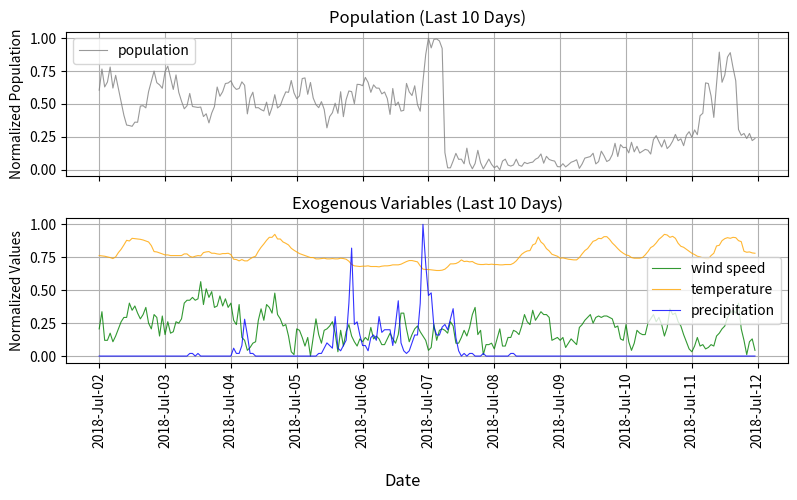

In [263]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 任意の期間設定（例: 最後のxx日間）
xx = 10
subset_start = -xx * 24  # xx日間分のデータ（時間単位で扱う場合）

# 2行1列のグラフを作成（任意の期間のみ表示）
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=template1, sharex=True)

# アルファ値の設定
alpha = 0.8

### 上段：任意の期間（最後のxx日間）の人口データ
ax1.plot_date(timeLine[subset_start:], y_population_normalize[subset_start:], '-', label='population', color='gray', linewidth=0.8, alpha=alpha)
ax1.legend()
ax1.grid()
ax1.set_title(f'Population (Last {xx} Days)')
ax1.set_ylabel('Normalized Population')  # y軸のラベル

### 下段：任意の期間（最後のxx日間）の気象データ（風速、気温、降水量）
ax2.plot_date(timeLine[subset_start:], y_windspeed_normalize[subset_start:], '-', label='wind speed', color='green', linewidth=0.8, alpha=alpha)
ax2.plot_date(timeLine[subset_start:], y_temperature_normalize[subset_start:], '-', label='temperature', color='orange', linewidth=0.8, alpha=alpha)
ax2.plot_date(timeLine[subset_start:], y_precipitation_normalize[subset_start:], '-', label='precipitation', color='blue', linewidth=0.8, alpha=alpha)
ax2.legend()
ax2.grid()
ax2.set_title(f'Exogenous Variables (Last {xx} Days)')
ax2.set_ylabel('Normalized Values')

# 横軸の設定（期間のフォーマット）
locator = mdates.DayLocator(interval=1)  # 1日単位で表示
formatter = mdates.DateFormatter('%Y-%b-%d')  # 年-月-日形式で表示

# 日付のフォーマットを設定
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

# x軸のラベルを縦向きに回転
ax2.tick_params(axis='x', rotation=90)

# x軸のラベルを表示
fig.supxlabel('Date')

# レイアウトの調整
plt.tight_layout()
plt.show()

呼び出した外生変数を統合したdataframeを作成

In [264]:
import pandas as pd

# DatetimeIndex をデータフレームに変換
df_timeLine = pd.DataFrame(timeLine)

# 他のデータをリセットインデックスで結合
df_pop_reset = df_pop[['population']].reset_index(drop=True)
df_weather_reset = df_weather[['prec', 'temp', 'wind']].reset_index(drop=True)
df_warnings_reset = df_warnings.reset_index(drop=True)

# 横方向に結合
df_ex = pd.concat([df_timeLine, df_pop_reset, df_weather_reset], axis=1)
df_ex = pd.concat([df_ex,df_warnings_reset], axis=1)

# 時系列をインデックスに設定
df_ex = df_ex.set_index('time')

print(df_ex)

                     population  prec  temp  wind      雷注意報  大雨注意報  洪水注意報  \
time                                                                        
2016-01-01 00:00:00         789   0.0   3.0   0.9  0.000000    0.0    0.0   
2016-01-01 01:00:00         702   0.0   2.0   0.3  0.000000    0.0    0.0   
2016-01-01 02:00:00         809   0.0   1.7   0.6  0.000000    0.0    0.0   
2016-01-01 03:00:00         846   0.0   0.9   0.3  0.000000    0.0    0.0   
2016-01-01 04:00:00         716   0.0   1.0   1.0  0.000000    0.0    0.0   
...                         ...   ...   ...   ...       ...    ...    ...   
2018-07-11 19:00:00         412   0.0  26.8   1.1  1.000000    0.0    0.0   
2018-07-11 20:00:00         363   0.0  26.5   0.1  1.000000    0.0    0.0   
2018-07-11 21:00:00         412   0.0  26.6   1.0  0.216667    0.0    0.0   
2018-07-11 22:00:00         343   0.0  26.3   1.2  0.000000    0.0    0.0   
2018-07-11 23:00:00         363   0.0  26.2   0.4  0.000000    0.0    0.0   

データの欠損値の補完

In [265]:
df_ex['temp'].isna()

time
2016-01-01 00:00:00    False
2016-01-01 01:00:00    False
2016-01-01 02:00:00    False
2016-01-01 03:00:00    False
2016-01-01 04:00:00    False
                       ...  
2018-07-11 19:00:00    False
2018-07-11 20:00:00    False
2018-07-11 21:00:00    False
2018-07-11 22:00:00    False
2018-07-11 23:00:00    False
Name: temp, Length: 22152, dtype: bool

In [266]:
import pandas as pd
import numpy as np

# 例: df_trainの作成

for name_var in df_ex.columns:
    nan_locations = df_ex[df_ex[name_var].isna()]

    # NaNが見つかった場合のみ表示
    if not nan_locations.empty:
        print(f"{name_var} のNaNの場所と値:")
        print(nan_locations)
        print()

        # NaNを一つ前のデータで上書きする
        df_ex.loc[:, name_var] = df_ex[name_var].ffill()


上に表示があればデータに欠損値あり．注意！！

# LSTM



In [267]:
# ライブラリのインポート
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch

from torch import nn,optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import transforms
from torchinfo import summary
from torch.autograd import Variable



## Normalize dataframe values

data split

In [268]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

if exDataIsAll:
    df_ex_standard =scaler.fit_transform(df_ex)
else:
    df_ex_standard = scaler.fit_transform(df_ex[['population']])

# testデータの正規化を戻すためのmax,minを抽出
max_avetem= max(df_ex['population'])
min_avetem= min(df_ex['population'])
max_avetem,min_avetem

df_ex_standard

array([[0.57277734],
       [0.5043273 ],
       [0.58851298],
       ...,
       [0.2761605 ],
       [0.22187254],
       [0.23760818]])

In [269]:
# trainのデータ行数を求める．
array_true_false = df_ex.index < split_date
print(array_true_false)
true_count=np.sum(array_true_false)
print(true_count)  # <- trainデータ個数


# train / test に分割
df_train = df_ex_standard[:true_count]
df_test = df_ex_standard[true_count:]

n_dim = df_train.shape[1]

print()
print('df_train')
print(df_train)
print()
print('df_test')
print(df_test)


[ True  True  True ... False False False]
21888

df_train
[[0.57277734]
 [0.5043273 ]
 [0.58851298]
 ...
 [0.48623131]
 [0.6711251 ]
 [0.64752164]]

df_test
[[0.50275374]
 [0.64280094]
 [0.77340677]
 [0.74193548]
 [0.60110149]
 [0.56333596]
 [0.65145555]
 [0.63335956]
 [0.51455547]
 [0.50904799]
 [0.58221873]
 [0.43902439]
 [0.56412274]
 [0.61526357]
 [0.51612903]
 [0.45318647]
 [0.64437451]
 [0.63493312]
 [0.61919748]
 [0.49881983]
 [0.40676633]
 [0.46892211]
 [0.74586939]
 [0.60660897]
 [0.60503541]
 [0.76553895]
 [0.62942565]
 [0.66640441]
 [0.7804878 ]
 [0.62077105]
 [0.71754524]
 [0.61683714]
 [0.5177026 ]
 [0.41463415]
 [0.33988985]
 [0.33595594]
 [0.33044847]
 [0.36191975]
 [0.36113297]
 [0.48387097]
 [0.4870181 ]
 [0.47049567]
 [0.59402046]
 [0.67033832]
 [0.7498033 ]
 [0.66168371]
 [0.64516129]
 [0.61919748]
 [0.74586939]
 [0.78756884]
 [0.69944925]
 [0.61054288]
 [0.72069237]
 [0.58851298]
 [0.52163651]
 [0.46341463]
 [0.48623131]
 [0.57985838]
 [0.48072384]
 [0.47757671]
 [0

## Data slice


In [270]:

import numpy as np

window_size = window_size # ウィンドウサイズ（24時間）
forecast_steps = 1  # xx時間後を予測
n_data = len(df_ex) - window_size - forecast_steps + 1

# 訓練データとテストデータのサイズを変更
n_train = len(df_train) - window_size - forecast_steps + 1
n_test = len(df_test) - window_size - forecast_steps + 1

# 正解データを準備________________________________________
train = np.zeros((n_train, window_size, n_dim))
train_labels = np.zeros((n_train, n_dim))
for i in range(n_train):
    train[i] = df_train[i:i+window_size]
    train_labels[i] = df_train[i + window_size + forecast_steps - 1]  # 24時間後のデータを取得

# テストデータを準備______________________________________
test = np.zeros((n_test, window_size, n_dim))
test_labels = np.zeros((n_test, n_dim))
for i in range(n_test):
    test[i] = df_test[i:i+window_size]
    test_labels[i] = df_test[i + window_size + forecast_steps - 1]  # 24時間後のデータを取得

train_labels = train_labels[:, 0]  # 最初の列のみを使用

print(f'train:{train.shape}')
print(f'train_labels:{train_labels.shape}')
print()
print(test.shape)
print(f'test_labels:{test_labels.shape}')

train:(21864, 24, 1)
train_labels:(21864,)

(240, 24, 1)
test_labels:(240, 1)


## Define LSTM model

In [271]:
# その他の必要なコード
train_torch = torch.tensor(train, dtype=torch.float)
labels = torch.tensor(train_labels, dtype=torch.float)
dataset = TensorDataset(train_torch, labels)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

train_torch = torch.tensor(train, dtype=torch.float)
labels = torch.tensor(train_labels, dtype=torch.float)
dataset = torch.utils.data.TensorDataset(train_torch, labels)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [272]:
if num_of_lstm_layer==1:
    # ##1層LSTM
    # 多変量を入力して、１変数の予測結果を返すLSTNモデル.
    class MyLSTM(nn.Module):
        def __init__(self, feature_size, hidden_dim, n_layers):
            super(MyLSTM, self).__init__()

            self.feature_size = feature_size
            self.hidden_dim = hidden_dim
            self.n_layers = n_layers
            self.n_output = 1

            self.lstm = nn.LSTM(feature_size, hidden_dim, num_layers=n_layers, batch_first=True)
            self.fc = nn.Linear(hidden_dim, self.n_output)

        def forward(self, x):
            # hidden state
            h_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim))
            # cell state
            c_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim))
            
            output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
            hn = hn.view(-1, self.hidden_dim) 
            y = self.fc(hn)
            y = y.reshape(self.n_output, -1)

            return y.squeeze()

In [273]:
if num_of_lstm_layer>=2:
    ##2層LSTM
    class MyLSTM(nn.Module):
        def __init__(self, feature_size, hidden_dim, n_layers=2):  # デフォルトで2層
            super(MyLSTM, self).__init__()

            self.feature_size = feature_size
            self.hidden_dim = hidden_dim
            self.n_layers = n_layers
            self.n_output = 1

            # 2層のLSTM
            self.lstm = nn.LSTM(feature_size, hidden_dim, num_layers=n_layers, batch_first=True)
            self.fc = nn.Linear(hidden_dim, self.n_output)

        def forward(self, x):
            # hidden state
            h_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim))
            # cell state
            c_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim))
            
            # LSTMの2層を通過
            output, (hn, cn) = self.lstm(x, (h_0, c_0))

            # hnの形状を(batch_size, hidden_dim)に変換
            hn = hn[-1]  # 最終タイムステップの出力を使用

            # 全結合層を通して最終出力を取得
            y = self.fc(hn)

            return y.squeeze()  # (batch_size,) にする

In [274]:

if exDataIsAll:
    feature_size  = 12
else:
    feature_size  = 1

n_hidden  = 64
n_layers  = num_of_lstm_layer

net = MyLSTM(feature_size, n_hidden, n_layers)
print(f'LSTM_layer: {num_of_lstm_layer}')
summary(net)

LSTM_layer: 1


Layer (type:depth-idx)                   Param #
MyLSTM                                   --
├─LSTM: 1-1                              17,152
├─Linear: 1-2                            65
Total params: 17,217
Trainable params: 17,217
Non-trainable params: 0

## Change epoch, Learning

In [275]:
func_loss = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
    ## 最適化を図るための仕組みとして，Adamを使う．
loss_history = []
device = torch.device("cuda:0" if torch.cuda. is_available() else "cpu")
epochs = epochs
print(f'epochs: {epochs}')
net.to(device)

epochs: 30


MyLSTM(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [276]:
for i in range(epochs+1):
    net.train()
    tmp_loss = 0.0
    for j, (x, t) in enumerate(train_loader):
        x = x.to(device)
        optimizer.zero_grad()
        y = net(x) 
        y = y.to('cpu')
        loss = func_loss(y, t)
        loss.backward()
        optimizer.step() 
        tmp_loss += loss.item()
    tmp_loss /= j+1
    loss_history.append(tmp_loss)
    print('Epoch:', i, ', Loss_Train:', tmp_loss)

Epoch: 0 , Loss_Train: 0.013511882695963073
Epoch: 1 , Loss_Train: 0.005923085449786301
Epoch: 2 , Loss_Train: 0.00517118800219083
Epoch: 3 , Loss_Train: 0.0050574224571593935
Epoch: 4 , Loss_Train: 0.005015680806068649
Epoch: 5 , Loss_Train: 0.00497004363960886
Epoch: 6 , Loss_Train: 0.005022492118817019
Epoch: 7 , Loss_Train: 0.00488054672220711
Epoch: 8 , Loss_Train: 0.004870368000283314
Epoch: 9 , Loss_Train: 0.00483166665582215
Epoch: 10 , Loss_Train: 0.00484295628422991
Epoch: 11 , Loss_Train: 0.004805639435194041
Epoch: 12 , Loss_Train: 0.004793614309079597
Epoch: 13 , Loss_Train: 0.004803416555426056
Epoch: 14 , Loss_Train: 0.004767438893108384
Epoch: 15 , Loss_Train: 0.004789307887110402
Epoch: 16 , Loss_Train: 0.0047699962851553285
Epoch: 17 , Loss_Train: 0.004750044507176032
Epoch: 18 , Loss_Train: 0.004749822583490689
Epoch: 19 , Loss_Train: 0.004788007736968541
Epoch: 20 , Loss_Train: 0.0047621078665330135
Epoch: 21 , Loss_Train: 0.004743998204439617
Epoch: 22 , Loss_Train

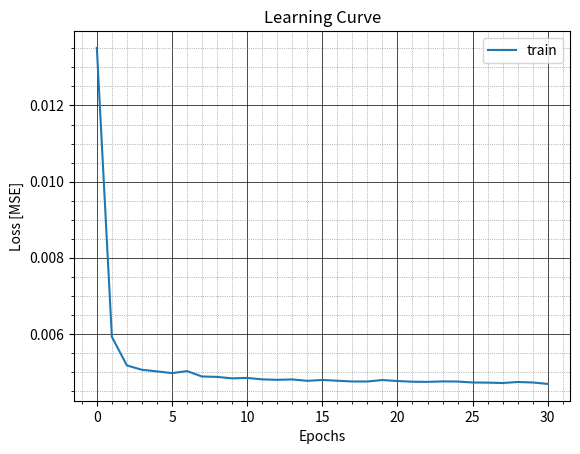

In [277]:
plt.plot(range(len(loss_history)), loss_history, label='train')
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Loss [MSE]")

# 主グリッドの設定
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
# 補助グリッドの設定
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

# # 横軸をtmpずつ表示させる設定
# tmp=20
# plt.xticks(range(0, len(loss_history) + 1, tmp))
plt.title('Learning Curve') #学習曲線というらしいわ
graph_loss=f'{directory}result_{dir_str}_loss.png'
plt.savefig(graph_loss,dpi=300)
plt.show()

# Forecasting

**Train data でモデル性能をチェック**


In [278]:
# predicted_train_plot = []
# net.eval()

# for k in range(n_train):
#     x = train_torch[k].clone().detach()
#     x = x.reshape(1, window_size, feature_size)
#     x = x.to(device).float()
#     y = net(x)
#     y = y.to('cpu')
#     predicted_train_plot.append(y[0].item())

In [279]:
# fig, ax = plt.subplots(figsize=(30,8))

# plt.plot(range(len(df_train)), df_train[:, 0], label='Observed')
# plt.plot(range(window_size, window_size+len(predicted_train_plot)), predicted_train_plot, label='Predicted')
# plt.legend()

# # 主グリッドの設定
# plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
# # 補助グリッドの設定
# plt.minorticks_on()
# plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
# plt.title('Predicted population (Normalization)')
# plt.xlabel('data')
# plt.ylabel('population[standard]')
# plt.show()

**Test data でモデル性能をチェック**

以下，observed data を用いて予測をする場合

In [280]:
predicted_test_plot = []
net.eval()

for k in range(n_test):
    x = torch.tensor(test[k])
    x = x.reshape(1, window_size, feature_size)
    x = x.to(device).float()
    y = net(x)
    y = y.to('cpu')
    predicted_test_plot.append(y.item())  # y[0].item() を y.item() に変更

以下，predicted data を用いて予測をする場合

In [281]:
# # test data 50個目のデータ（下の正規化グラフの横軸50の箇所）からpredicted dataを用いる
# fake_point=100
# split_point=fake_point-window_size

# fake_test=test
# predicted_test_plot = []
# net.eval()

# for k in range(n_test):
#     # print(k)
#     if (k!=0):
#         for iii in range(k):
#             fake_test[k][23-iii,0]=predicted_test_plot[-iii]
#             if iii>23:
#                 break
#     if k>split_point:
#         x = torch.tensor(fake_test[k])
#     else:
#         x = torch.tensor(test[k])

#     x = x.reshape(1, window_size, feature_size)
#     x = x.to(device).float()
#     y = net(x)
#     y = y.to('cpu')
#     predicted_test_plot.append(y[0].item())
    

**正規化グラフ表示**

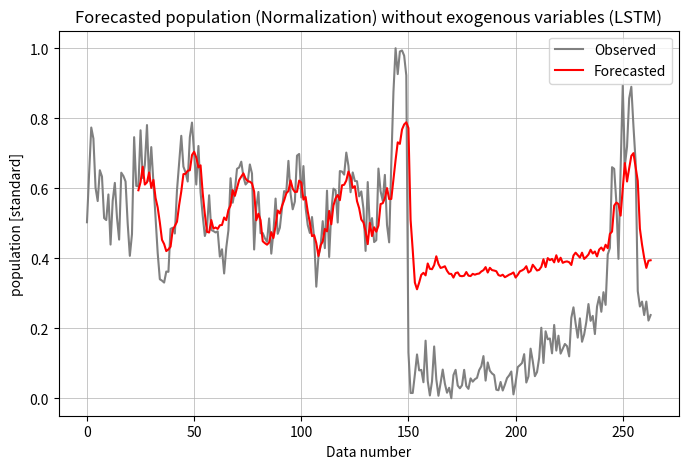

In [282]:
fig, ax = plt.subplots(figsize=template1)

plt.plot(range(len(df_test)), df_test[:, 0], label='Observed',color='gray')
plt.plot(range(window_size, window_size+len(predicted_test_plot)), predicted_test_plot, label='Forecasted',color='red')
plt.legend()

# 主グリッドの設定
plt.grid(which='major', linestyle='-', linewidth='0.5')
if exDataIsAll:
    add_title_name  = ' with Exogenous variables'
else:
    add_title_name  = ' without exogenous variables'


plt.title('Forecasted population (Normalization)'+add_title_name+' (LSTM)')
plt.xlabel('Data number')
plt.ylabel('population [standard]')
plt.show()

正規化を戻す


In [283]:
#Observed
df_test_inversed = np.array(df_test[:,0]) * (max_avetem-min_avetem) + min_avetem

#Predicted
predicted_test_plot_inversed = np.array(predicted_test_plot) * (max_avetem-min_avetem) + min_avetem


データの加工

In [284]:

import pandas as pd

#Observed
df_test_inversed_plt = df_test_inversed # ndarray型なので，20個目から最後までの値が格納される

#Predicted
predicted_test_plot_inversed_plt = predicted_test_plot_inversed

# 日時データを生成します（1時間おきのデータを使用）
date_rng = pd.date_range(start=test_start_date, periods=len(df_test_inversed_plt), freq='h')
predicted_date_rng = date_rng[-len(predicted_test_plot_inversed_plt):]

グラフ表示

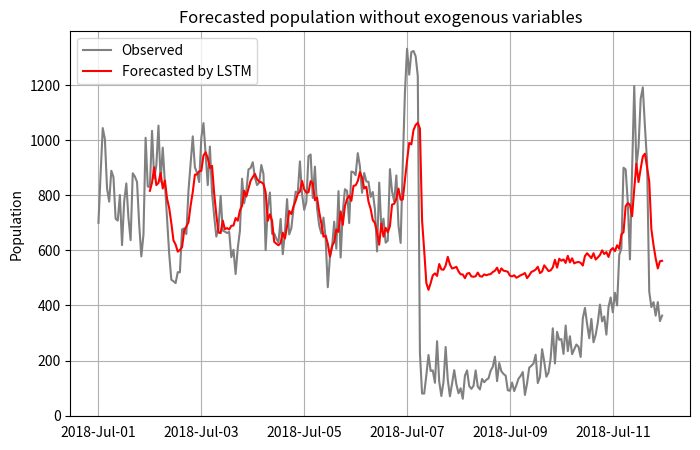

In [285]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# プロット
fig, ax = plt.subplots(figsize=template1)  # サイズを指定する

# データのプロット
ax.plot(date_rng, df_test_inversed_plt, label='Observed', linewidth=1.5, color='gray')
ax.plot(predicted_date_rng, predicted_test_plot_inversed_plt, label='Forecasted by LSTM', linewidth=1.5, color='red')
ax.legend(loc='upper left')

# 日時のフォーマット設定
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax.grid()

# フォーマットを月単位に設定
formatter = mdates.DateFormatter('%Y-%b-%d')  # 年-月形式で表示
ax.xaxis.set_major_formatter(formatter)

# 0度のラベルを削除
ax.tick_params(axis='x', which='both', bottom=False, top=False)

if exDataIsAll:
    add_title_name  = ' with Exogenous variables'
else:
    add_title_name  = ' without exogenous variables'

plt.title('Forecasted population' + add_title_name)
plt.ylabel('Population')
graph_forecast = f'{directory}result_{dir_str}_forecast.png'
plt.savefig(graph_forecast, dpi=300)
plt.show()

# MAPE/MSE

In [286]:
import numpy as np
# MAPEの計算
def calculate_mape(true_values, predicted_values):
    true_values, predicted_values = np.array(true_values), np.array(predicted_values)
    return np.mean(np.abs((true_values - predicted_values) / true_values)) * 100


# MSEを計算する関数
def calculate_mse(true_values, predicted_values):
    true_values, predicted_values = np.array(true_values), np.array(predicted_values)
    return np.mean((true_values - predicted_values) ** 2)

def calculate_rmse(true_values, predicted_values):
    return (calculate_mse(true_values, predicted_values) ** 0.5)

# 後からpredictedの数だけ戻り，observedとpredictedを対応させる確認する．
mape = calculate_mape(df_test_inversed_plt[-len(predicted_test_plot_inversed_plt):], predicted_test_plot_inversed_plt) 
mse = calculate_mse(df_test_inversed_plt[-len(predicted_test_plot_inversed_plt):], predicted_test_plot_inversed_plt)
rmse = calculate_rmse(df_test_inversed_plt[-len(predicted_test_plot_inversed_plt):], predicted_test_plot_inversed_plt)

print(f'MAPE: {mape:.2f}%')
print(f'MSE : {mse:.2f}')
print(f'RMSE : {rmse:.2f}')


MAPE: 102.57%
MSE : 60580.85
RMSE : 246.13


$
\text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100
$

$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$

---

# Pickle 

In [287]:
import pickle
import os

# pickle #####################
# 保存する時間情報

### 保存したい複数の変数
a = train_start_date
b = train_end_date
c = test_start_date
d = test_end_date
e = PATH_mesh
f = window_size
g = df_test
h = predicted_test_plot
i = date_rng
j = df_test_inversed_plt
k = predicted_date_rng
l = predicted_test_plot_inversed_plt
m = df_ex

### pickleで保存（書き出し）: 辞書にして複数の変数を保存
pickle_path = os.path.join(directory, f'vars_exo{exDataIsAll}.pickle')
with open(pickle_path, mode='wb') as fo:
    pickle.dump({
        'train_start_date': a, 
        'train_end_date': b, 
        'test_start_date': c, 
        'test_end_date': d, 
        'date_rng': i, 
        'df_test_inversed_plt': j, 
        'predicted_date_rng': k, 
        'predicted_test_plot_inversed_plt': l,
        'df_ex': m
    }, fo)

In [288]:
# 終了時刻を記録
end_time = datetime.datetime.now()

# 経過時間を計算（分単位）
elapsed_time = (end_time - start_time).total_seconds() / 60

# 結果を表示
print(f"Elapsed time: {elapsed_time:.2f} min")

Elapsed time: 1.28 min


In [289]:
import os

md_file_path = os.path.join(directory, f'report.md')
with open(md_file_path, 'w') as md_file:
    md_file.write(f"""
# Report for This LSTM model (Elapsed time: {elapsed_time:.2f} min)

File created time: {dir_str}

## Result 
<img src="{os.path.basename(graph_loss)}" width='600'/>
<img src="{os.path.basename(graph_forecast)}" width='600'/>

- MAPE\t{mape:.1f}%
- MSE \t{mse:.2f}
- RMSE : {rmse:.2f}

## Pickle path
{pickle_path}

## Mesh path
{PATH_mesh}

## Imput vars

### Exo data:
- {exDataIsAll}

### Exogenous data:
- {', '.join(df_ex.columns)}
 
### Period:
- train_start_date    = {train_start_date}
- train_end_date      = {train_end_date}
- test_start_date     = {test_start_date}  
- test_end_date       = {test_end_date}

### LSTM parameter
- window_size\t{window_size}
- epochs\t{epochs}
- ...
- feature_size\t{feature_size}
- n_hidden\t{n_hidden}
- n_layers\t{n_layers}
- net

     {net}


""")
    